# Univariate CNN

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

In [2]:
# fix tensorflow gpu problems
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [3]:
# check gpu support
gpus = tf.config.list_physical_devices('GPU')
print(len(gpus))
print(tf.test.is_built_with_gpu_support())
print(tf.test.is_built_with_cuda())
print(tf.test.gpu_device_name())

0
True
True



## 1. Load the dataset

In [4]:
df = pd.read_csv('Lumos5G-v1.0.csv',
                index_col=['run_num', 'seq_num'])
df.head(5)

abstractSignalStr   latitude  longitude  movingSpeed  \
run_num seq_num                                                         
1       1.0                      2  44.975314 -93.259316     0.094889   
        2.0                      2  44.975311 -93.259311     0.876634   
        3.0                      2  44.975305 -93.259292     2.225798   
        4.0                      2  44.975293 -93.259258     3.180726   
        5.0                      2  44.975278 -93.259214     3.751234   

                 compassDirection        nrStatus  lte_rssi  lte_rsrp  \
run_num seq_num                                                         
1       1.0                   150  NOT_RESTRICTED     -61.0       -94   
        2.0                   117  NOT_RESTRICTED     -61.0       -94   
        3.0                   113  NOT_RESTRICTED     -61.0       -94   
        4.0                   114  NOT_RESTRICTED     -59.0       -95   
        5.0                   115  NOT_RESTRICTED     -59.0       -95   

                 lte_rsrq     lte_rssnr  nr_ssRsrp  nr_ssRsrq  nr_ssSinr  \
run_num seq_num                                                            
1       1.0         -14.0  2.147484e+09        NaN        NaN        NaN   
        2.0         -14.0  2.147484e+09        NaN        NaN        NaN   
        3.0         -14.0  2.147484e+09        NaN        NaN        NaN   
        4.0         -16.0  2.147484e+09        NaN        NaN        NaN   
        5.0         -16.0  2.147484e+09        NaN        NaN        NaN   

                 Throughput mobility_mode trajectory_direction  tower_id  
run_num seq_num                                                           
1       1.0              78       driving                   CW        16  
        2.0             117       driving                   CW        16  
        3.0             110       driving                   CW        16  
        4.0             108       driving                   CW        16  
        5.0             100       driving                   CW        16

In [5]:
# select columns
ndf = df[["Throughput"]]
ndf.head()

Throughput
run_num seq_num            
1       1.0              78
        2.0             117
        3.0             110
        4.0             108
        5.0             100

In [6]:
max_throughput = ndf.max()
min_throughput = ndf.min()
print(f'Max throughput: {max_throughput}')
print(f'Min throughput: {min_throughput}')
max_throughput = max_throughput.item() # get python int!

Max throughput: Throughput    1920
dtype: int64
Min throughput: Throughput    0
dtype: int64


In [7]:
# Min-Max Scaling
df=(ndf-ndf.min())/(ndf.max()-ndf.min())
df.head()

Throughput
run_num seq_num            
1       1.0        0.040625
        2.0        0.060937
        3.0        0.057292
        4.0        0.056250
        5.0        0.052083

## 2. Create Train-Test Sets

In [8]:
# split function into sequences
def multistep_split(seq, n_steps_in, n_steps_out):
    X = list()
    y = list()
    for i in range(len(seq)):
        # pattern end
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        if out_end_ix > len(seq):
            break
        seq_x = seq[i:end_ix]
        seq_y = seq[end_ix:out_end_ix, -1]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [9]:
# separately splits runs into sequences
run_max=df.index.max()[0]
seconds_in = 20
seconds_out = 20 
X_list = list()
y_list = list()
for run_num in range(1, run_max+1):
    run = df.loc[run_num].values
    X, y = multistep_split(run.astype('float32'), n_steps_in=seconds_in, n_steps_out=seconds_out)
    X_list.append(X)
    y_list.append(y)
X = np.concatenate(X_list)
y = np.concatenate(y_list)
X = X.reshape((X.shape[0], X.shape[1]))
print(X.shape)
print(y.shape)

(63516, 20)
(63516, 20)


In [10]:
ratio=0.7
train_size = int(ratio*X.shape[0])
X_train = X[:train_size]
y_train = y[:train_size]
X_test = X[train_size:]
y_test = y[train_size:]
# reshape inputs into 3D
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(44461, 20, 1)
(44461, 20)
(19055, 20, 1)
(19055, 20)


## 3. Define CNN

In [29]:
def cnn(seconds_in, seconds_out, lr=0.0001):
    # define layers
    inputs = tf.keras.Input(shape=(seconds_in, 1))
    conv1 = tf.keras.layers.Conv1D(filters=32, kernel_size=4, activation='relu')
    conv2 = tf.keras.layers.Conv1D(filters=16, kernel_size=4, activation='relu')
    flat = tf.keras.layers.Flatten()
    dense1 = tf.keras.layers.Dense(64, activation='relu')
    outputs = tf.keras.layers.Dense(seconds_out, activation='linear')
    layers = [inputs, conv1, conv2, flat, dense1, outputs]
    # create model
    model = tf.keras.models.Sequential(layers)
    model.summary()
    # compile model
    opt = tf.keras.optimizers.Adam(learning_rate=lr)
    model.compile(optimizer=opt, loss='mean_squared_error')
    return model

## 4. Train CNN

In [30]:
model = cnn(seconds_in, seconds_out, lr=0.0001)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_10 (Conv1D)           (None, 17, 32)            160       
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 14, 16)            2064      
_________________________________________________________________
flatten_4 (Flatten)          (None, 224)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)                14400     
_________________________________________________________________
dense_7 (Dense)              (None, 20)                1300      
Total params: 17,924
Trainable params: 17,924
Non-trainable params: 0
_________________________________________________________________


In [31]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  min_delta=0.0001,
                                                  patience=20,
                                                  verbose=0,
                                                  mode='auto',
                                                  restore_best_weights=True)
history = model.fit(X_train,
                    y_train,
                    epochs=50,
                    batch_size=32,
                    validation_data=(X_test, y_test),
                    callbacks=[early_stopping],
                    verbose=1)

Epoch 1/50
1390/1390 [==============================] - 3s 2ms/step - loss: 0.0441 - val_loss: 0.0349
Epoch 2/50
1390/1390 [==============================] - 3s 2ms/step - loss: 0.0367 - val_loss: 0.0347
Epoch 3/50
1390/1390 [==============================] - 3s 2ms/step - loss: 0.0364 - val_loss: 0.0347
Epoch 4/50
1390/1390 [==============================] - 3s 2ms/step - loss: 0.0363 - val_loss: 0.0345
Epoch 5/50
1390/1390 [==============================] - 3s 2ms/step - loss: 0.0362 - val_loss: 0.0347
Epoch 6/50
1390/1390 [==============================] - 3s 2ms/step - loss: 0.0359 - val_loss: 0.0345
Epoch 7/50
1390/1390 [==============================] - 3s 2ms/step - loss: 0.0361 - val_loss: 0.0347
Epoch 8/50
1390/1390 [==============================] - 3s 2ms/step - loss: 0.0355 - val_loss: 0.0345
Epoch 9/50
1390/1390 [==============================] - 3s 2ms/step - loss: 0.0360 - val_loss: 0.0344
Epoch 10/50
1390/1390 [==============================] - 3s 2ms/step - loss: 0.035

Minimal Loss: 0.0344
RMSE: 355.9 Mbps


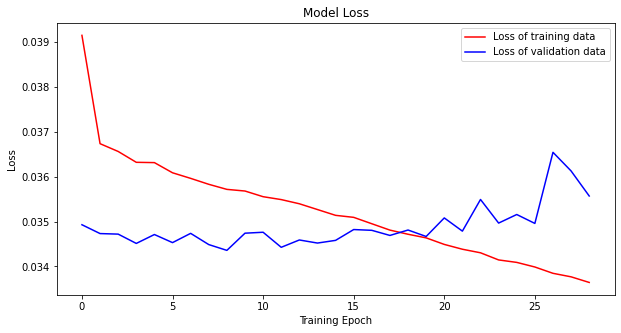

In [32]:
loss = history.history['loss']
val_loss = history.history['val_loss']
min_mse = min(val_loss)
print(f'Minimal Loss: {min_mse:.4f}')
print(f'RMSE: {np.sqrt(min_mse)*max_throughput:.1f} Mbps')
plt.figure(figsize=(10,5))
plt.plot(loss, 'r', label='Loss of training data')
plt.plot(val_loss, 'b-', label='Loss of validation data')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Training Epoch')
plt.legend()
plt.show()

## 5. Test-Predict Comparision

Forecast MSE of the example: 0.0282


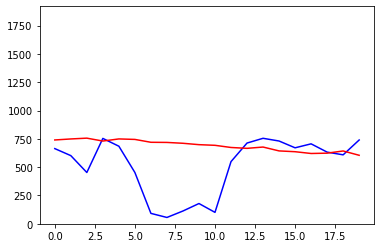

In [34]:
n = 200 # example number
y_true = y_test[n]
x_in = X_test[n].reshape((1, seconds_in, 1))
y_pred = model.predict(x_in).flatten()
plt.plot(y_true*max_throughput, 'b')
plt.plot(y_pred*max_throughput, 'r')
plt.ylim(0, max_throughput)
print(f'Forecast MSE of the example: {mean_squared_error(y_true, y_pred):.4f}')
plt.show()